In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
sys.path.insert(0, "../timeseries/")

In [3]:
from scraper import (
    get_coin_returns,
)
from forecast import find_least_bitcoin_correl, evaluate_models
from pandas.plotting import autocorrelation_plot

### Returns of 50 largest crypto tokens (per market cap)

In [4]:
coin_returns = get_coin_returns()

In [5]:
coin_returns.tail()

,bitcoin,ethereum,tether,usd-coin,binancecoin,binance-usd,ripple,cardano,solana,dogecoin,...,internet-computer,decentraland,tezos,true-usd,filecoin,theta-token,axie-infinity,elrond-erd-2,bitcoin-cash-sv,helium
date,,,,,,,,,,,,,,,,,,,,,
2022-06-26,0.012377,0.012187,0.003286,0.003850,-0.004270,0.003874,-0.002568,-0.008705,-0.002139,0.019556,...,0.025987,0.088996,-0.003293,0.003011,-0.015101,0.051930,0.037048,-0.025189,-0.007138,0.020816
2022-06-27,-0.021977,-0.034597,0.001980,-0.001940,-0.022446,-0.003051,-0.019037,-0.013764,-0.068133,0.075748,...,-0.076384,-0.083219,-0.058300,0.000289,-0.038850,-0.086175,-0.090728,-0.103681,-0.043733,-0.084335
2022-06-28,-0.014313,-0.005838,-0.001990,-0.000432,-0.002946,0.002384,-0.018335,-0.009504,-0.025251,-0.016834,...,-0.008660,0.032091,0.104951,0.000286,-0.011011,-0.011189,-0.017992,0.012124,-0.013960,0.024697
2022-06-29,-0.022598,-0.042447,-0.000235,0.000107,-0.029181,-0.001818,-0.046011,-0.034029,-0.082466,-0.089879,...,-0.051978,-0.084125,-0.049983,0.000030,-0.048441,-0.050717,-0.039728,-0.072242,-0.050574,-0.090312
2022-06-30,-0.008579,-0.039026,0.000663,-0.000154,-0.033694,0.002055,-0.023183,-0.010603,-0.039943,0.054539,...,-0.017041,-0.010966,-0.033808,0.000107,-0.010402,-0.027898,-0.059439,-0.032769,-0.000665,-0.041464


### Correlation-Matrix

In [6]:
coin_returns.dropna().corr().head()

,bitcoin,ethereum,tether,usd-coin,binancecoin,binance-usd,ripple,cardano,solana,dogecoin,...,internet-computer,decentraland,tezos,true-usd,filecoin,theta-token,axie-infinity,elrond-erd-2,bitcoin-cash-sv,helium
bitcoin,1.000000,0.918653,-0.133713,-0.091684,0.871361,-0.070695,0.793671,0.796521,0.741243,0.723397,...,0.698255,0.595334,0.795877,-0.271602,0.728468,0.663195,0.701772,0.626959,0.676570,0.647676
ethereum,0.918653,1.000000,-0.168110,-0.127155,0.900294,-0.077774,0.842649,0.800272,0.821623,0.742289,...,0.710238,0.633396,0.843192,-0.296887,0.768076,0.708440,0.732059,0.728022,0.718576,0.706301
tether,-0.133713,-0.168110,1.000000,0.280043,-0.012980,0.321214,-0.043098,-0.052597,0.007565,0.060294,...,0.076551,0.249924,-0.122846,0.676831,0.003471,0.163319,-0.057004,-0.028540,-0.015508,-0.002293
usd-coin,-0.091684,-0.127155,0.280043,1.000000,-0.137174,0.189716,-0.148431,-0.137629,0.004289,-0.197309,...,-0.136047,0.106192,-0.123027,0.271611,-0.129664,0.041371,-0.085460,-0.051249,-0.063788,-0.070556
binancecoin,0.871361,0.900294,-0.012980,-0.137174,1.000000,-0.017776,0.886830,0.810616,0.821713,0.771719,...,0.797246,0.721760,0.847491,-0.193491,0.808836,0.747152,0.725412,0.751707,0.743847,0.708896


### Filter returns of coin with least correlation with Bitcoin 

In [7]:
series = find_least_bitcoin_correl(coin_returns)

In [8]:
series.tail()

,frax
date,
2022-06-26,0.000259
2022-06-27,-0.001740
2022-06-28,-0.000272
2022-06-29,-0.009858
2022-06-30,0.011436


<AxesSubplot:ylabel='Frequency'>

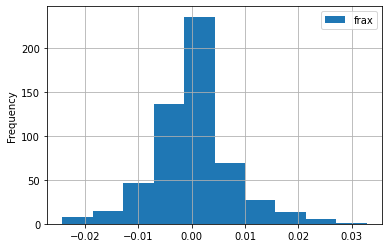

In [9]:
series.plot(kind="hist", grid=True)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

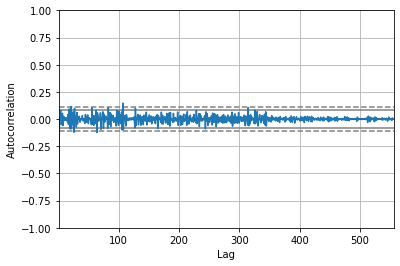

In [10]:
autocorrelation_plot(series)

In [15]:
# set parameters
p_values = range(0, 4)
d_values = [0, 1]
q_values = range(0, 4)

evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.258
ARIMA(0, 0, 1) RMSE=0.207
ARIMA(0, 0, 2) RMSE=0.206
ARIMA(0, 0, 3) RMSE=0.206
ARIMA(0, 1, 0) RMSE=0.433
ARIMA(0, 1, 1) RMSE=0.258
ARIMA(0, 1, 2) RMSE=0.211
ARIMA(0, 1, 3) RMSE=0.212
ARIMA(1, 0, 0) RMSE=0.217
ARIMA(1, 0, 1) RMSE=0.208
ARIMA(1, 0, 2) RMSE=0.208
ARIMA(1, 0, 3) RMSE=0.207
ARIMA(1, 1, 0) RMSE=0.303
ARIMA(1, 1, 1) RMSE=0.219
ARIMA(1, 1, 2) RMSE=0.206
ARIMA(1, 1, 3) RMSE=0.212
ARIMA(2, 0, 0) RMSE=0.218
ARIMA(2, 0, 1) RMSE=0.207
ARIMA(2, 0, 2) RMSE=0.207
ARIMA(2, 0, 3) RMSE=0.206
ARIMA(2, 1, 0) RMSE=0.283
ARIMA(2, 1, 1) RMSE=0.222
ARIMA(2, 1, 2) RMSE=0.217
ARIMA(2, 1, 3) RMSE=0.216
ARIMA(3, 0, 0) RMSE=0.214
ARIMA(3, 0, 1) RMSE=0.213
ARIMA(3, 0, 2) RMSE=0.210
ARIMA(3, 0, 3) RMSE=0.206
ARIMA(3, 1, 0) RMSE=0.258
ARIMA(3, 1, 1) RMSE=0.219
ARIMA(3, 1, 2) RMSE=0.220
ARIMA(3, 1, 3) RMSE=0.218
Best ARIMA(1, 1, 2) RMSE=0.206
